In [1]:
print("hello")

hello


In [ ]:
# =============================================================================
# 1. GOOGLE COLAB SETUP - MOUNT DRIVE & INSTALL PACKAGES
# =============================================================================

# Install required packages
%pip install -q torchinfo psutil

# =============================================================================
# SET WORKING DIRECTORY - CHANGE THIS TO YOUR DRIVE PATH
# =============================================================================
import os

# Đường dẫn local của bạn
WORKING_DIR = '.'  # Hoặc đường dẫn bất kỳ bạn muốn
os.makedirs(WORKING_DIR, exist_ok=True)
os.chdir(WORKING_DIR)
print(f"Working directory: {os.getcwd()}")

# =============================================================================
# IMPORTS
# =============================================================================
import urllib.request
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import gc
import time
import json
import math
import warnings
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
import torch.cuda.amp as amp

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# =============================================================================
# AUTO-DETECT GPU & SET OPTIMAL CONFIG FOR COLAB PRO
# =============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*60)
print("SYSTEM RESOURCES")
print("="*60)

if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"  GPU: {gpu_name}")
    print(f"  VRAM: {gpu_memory:.1f} GB")

    # Auto-set batch size based on GPU
BATCH_SIZE = 256
N_WORKERS = 8


# Check RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print(f"  RAM: {ram_gb:.1f} GB")

if ram_gb < 25:
    print("  WARNING: Low RAM! Enable High-RAM in Runtime settings")

# Training config
N_EPOCHS = 50
LEARNING_RATE = 0.0001
STATE_TOP_N = 15

# --- THÊM DÒNG NÀY ---
IMAGE_SIZE = 32

def create_directory(path):
    os.makedirs(path, exist_ok=True)
    print(f"  Created/Checked: {path}")

print(f"\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs: {N_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  DataLoader Workers: {N_WORKERS}")
print("="*60)


Note: you may need to restart the kernel to use updated packages.
Working directory: c:\Users\admin\Downloads\botnet


c:\Users\admin\Downloads\botnet\.venv\Scripts\python.exe: No module named pip
c:\Users\admin\Downloads\botnet\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SYSTEM RESOURCES
  GPU: NVIDIA GeForce RTX 4050 Laptop GPU
  VRAM: 6.4 GB
  RAM: 16.9 GB

CONFIGURATION
  Batch Size: 1024
  Epochs: 50
  Learning Rate: 0.0001
  DataLoader Workers: 8


In [3]:
# =============================================================================
# 3. DOWNLOAD DATASET (Will be saved to Google Drive)
# =============================================================================
# Data will be saved to: DRIVE_PATH/CTU-13-Dataset/
# This persists across sessions, so you only need to download once!

main_dir = './CTU-13-Dataset/'
create_directory(main_dir)

# Create subfolders for 13 scenarios
for i in range(1, 14):
    create_directory(os.path.join(main_dir, str(i)))

datasets = [
    (1, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/detailed-bidirectional-flow-labels/capture20110810.binetflow'),
    (2, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-43/detailed-bidirectional-flow-labels/capture20110811.binetflow'),
    (3, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-44/detailed-bidirectional-flow-labels/capture20110812.binetflow'),
    (4, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-45/detailed-bidirectional-flow-labels/capture20110815.binetflow'),
    (5, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-46/detailed-bidirectional-flow-labels/capture20110815-2.binetflow'),
    (6, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-47/detailed-bidirectional-flow-labels/capture20110816.binetflow'),
    (7, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-48/detailed-bidirectional-flow-labels/capture20110816-2.binetflow'),
    (8, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-49/detailed-bidirectional-flow-labels/capture20110816-3.binetflow'),
    (9, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-50/detailed-bidirectional-flow-labels/capture20110817.binetflow'),
    (10, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-51/detailed-bidirectional-flow-labels/capture20110818.binetflow'),
    (11, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-52/detailed-bidirectional-flow-labels/capture20110818-2.binetflow'),
    (12, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-53/detailed-bidirectional-flow-labels/capture20110819.binetflow'),
    (13, 'https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-54/detailed-bidirectional-flow-labels/capture20110815-3.binetflow')
]

def download_file(url, destination):
    try:
        if os.path.exists(destination):
            print(f"  [SKIP] File exists: {os.path.basename(destination)}")
            return True

        print(f"  Downloading: {os.path.basename(destination)}")
        with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc="  Progress") as t:
            def reporthook(blocknum, blocksize, totalsize):
                t.total = totalsize
                t.update(blocknum * blocksize - t.n)
            urllib.request.urlretrieve(url, destination, reporthook=reporthook)
        return True
    except Exception as e:
        print(f"Error downloading {url}: {str(e)}")
        return False

def check_csv_in_folder(folder_path):
    if not os.path.exists(folder_path): return False
    for file in os.listdir(folder_path):
        if file.endswith('.csv'): return True
    return False

print(f"\nStarting download for {len(datasets)} datasets...")
for idx, url in datasets:
    filename = url.split('/')[-1]
    destination = os.path.join(main_dir, str(idx), filename)
    folder_path = os.path.join(main_dir, str(idx))

    print(f"\n[{idx}/13] Dataset {idx}:")
    if check_csv_in_folder(folder_path):
        print(f"  [SKIP] CSV already exists.")
        continue
    download_file(url, destination)

print("\nDownload complete!")


  Created/Checked: ./CTU-13-Dataset/
  Created/Checked: ./CTU-13-Dataset/1
  Created/Checked: ./CTU-13-Dataset/2
  Created/Checked: ./CTU-13-Dataset/3
  Created/Checked: ./CTU-13-Dataset/4
  Created/Checked: ./CTU-13-Dataset/5
  Created/Checked: ./CTU-13-Dataset/6
  Created/Checked: ./CTU-13-Dataset/7
  Created/Checked: ./CTU-13-Dataset/8
  Created/Checked: ./CTU-13-Dataset/9
  Created/Checked: ./CTU-13-Dataset/10
  Created/Checked: ./CTU-13-Dataset/11
  Created/Checked: ./CTU-13-Dataset/12
  Created/Checked: ./CTU-13-Dataset/13

Starting download for 13 datasets...

[1/13] Dataset 1:
  [SKIP] CSV already exists.

[2/13] Dataset 2:
  [SKIP] CSV already exists.

[3/13] Dataset 3:
  [SKIP] CSV already exists.

[4/13] Dataset 4:
  [SKIP] CSV already exists.

[5/13] Dataset 5:
  [SKIP] CSV already exists.

[6/13] Dataset 6:
  [SKIP] CSV already exists.

[7/13] Dataset 7:
  [SKIP] CSV already exists.

[8/13] Dataset 8:
  [SKIP] CSV already exists.

[9/13] Dataset 9:
  [SKIP] CSV already exi

In [4]:
# =============================================================================
# 4. CONVERT BINETFLOW TO CSV
# =============================================================================

def rename(path_file, new_name):
    dir_path = os.path.dirname(path_file)
    path_new_name = os.path.join(dir_path, new_name)
    os.rename(path_file, path_new_name)

listDir = os.listdir(main_dir)
listCSV = []
print("Checking/Converting files...")

for subDir in sorted(listDir, key=lambda x: int(x) if x.isdigit() else 0):
    path_subDir = os.path.join(main_dir, subDir)
    if not os.path.isdir(path_subDir): continue

    # Check if CSV exists
    csv_files = [f for f in os.listdir(path_subDir) if f.endswith('.csv')]
    if csv_files:
        listCSV.append(os.path.join(path_subDir, csv_files[0]))
        continue

    # If no CSV, look for binetflow to rename
    binetflow_files = [f for f in os.listdir(path_subDir) if 'binetflow' in f]
    if binetflow_files:
        binetflow_file = os.path.join(path_subDir, binetflow_files[0])
        new_name = subDir + '.csv'
        rename(binetflow_file, new_name)
        listCSV.append(os.path.join(path_subDir, new_name))
        print(f"  Converted {binetflow_files[0]} -> {new_name}")

print(f"\nFound {len(listCSV)} CSV files:")
for csv in listCSV:
    print(f"  {csv}")


Checking/Converting files...

Found 13 CSV files:
  ./CTU-13-Dataset/1\1.csv
  ./CTU-13-Dataset/2\2.csv
  ./CTU-13-Dataset/3\3.csv
  ./CTU-13-Dataset/4\4.csv
  ./CTU-13-Dataset/5\5.csv
  ./CTU-13-Dataset/6\6.csv
  ./CTU-13-Dataset/7\7.csv
  ./CTU-13-Dataset/8\8.csv
  ./CTU-13-Dataset/9\9.csv
  ./CTU-13-Dataset/10\10.csv
  ./CTU-13-Dataset/11\11.csv
  ./CTU-13-Dataset/12\12.csv
  ./CTU-13-Dataset/13\13.csv


In [5]:
# =============================================================================
# DEFINING SCENARIOS
# =============================================================================
# Train scenarios: Neris, Murlo, Virut, Menti, Sogou (Đa dạng hóa dữ liệu train)
TRAIN_SCENARIOS = ['1', '2', '5','12','13','6','3','4', '8', '9','11']

# Test scenario: Rbot (Hoàn toàn mới, model chưa từng thấy)
TEST_SCENARIOS = ['10']

print(f"Training on Scenarios: {TRAIN_SCENARIOS}")
print(f"Testing on unseen Scenario: {TEST_SCENARIOS}")

# Hàm lọc file CSV theo scenario ID
def get_csv_paths(main_dir, scenario_ids):
    csv_paths = []
    for sid in scenario_ids:
        path = os.path.join(main_dir, sid)
        # Tìm file csv trong folder
        for file in os.listdir(path):
            if file.endswith('.csv'):
                csv_paths.append(os.path.join(path, file))
                break
    return csv_paths

# Lấy đường dẫn file thực tế
train_csvs = get_csv_paths(main_dir, TRAIN_SCENARIOS)
test_csvs = get_csv_paths(main_dir, TEST_SCENARIOS)

print(f"Found {len(train_csvs)} training files.")
print(f"Found {len(test_csvs)} testing files.")

Training on Scenarios: ['1', '2', '5', '12', '13', '6', '3', '4', '8', '9', '11']
Testing on unseen Scenario: ['10']
Found 11 training files.
Found 1 testing files.


In [6]:
# =============================================================================
# 5. PRE-COMPUTE GLOBAL STATISTICS
# =============================================================================
# This step calculates all statistics needed for on-the-fly transformation:
# - IP/Port frequencies for encoding
# - Global min/max for normalization
# - Column schema for consistency

from preprocessing_utils import quick_classify, calculate_global_frequencies, process_batch_fast_v2

print("="*70)
print("PRE-COMPUTING GLOBAL STATISTICS")
print("="*70)

target_csvs = train_csvs  # Use train scenarios
print(f"Processing {len(target_csvs)} CSV files...")

# --- Step 1: Calculate Global Frequencies ---
print("\n[1/4] Calculating global IP/Port frequencies...")
freq_dicts = calculate_global_frequencies(target_csvs)

# --- Step 2: Detect Top States ---
print("\n[2/4] Detecting top states...")
sample_df = pd.read_csv(target_csvs[0], nrows=100000)
sample_df['Label'] = sample_df['Label'].apply(quick_classify)
top_states = sample_df['State'].value_counts().nlargest(STATE_TOP_N).index.tolist()
print(f"  Top {STATE_TOP_N} states: {top_states}")
del sample_df
gc.collect()

# --- Step 3: Detect Column Schema ---
print("\n[3/4] Detecting column schema...")
expected_columns = None
cols_samples = []

for csv_file in target_csvs[:5]:  # Sample from first 5 files
    try:
        chunk = pd.read_csv(csv_file, nrows=5000)
        X_s, y_s, cols_s = process_batch_fast_v2(chunk, top_states, freq_dicts, expected_columns=None)
        if cols_s:
            cols_samples.extend(cols_s)
    except Exception as e:
        continue

if cols_samples:
    expected_columns = list(dict.fromkeys(cols_samples))  # Preserve order, remove duplicates
    print(f"  Detected {len(expected_columns)} feature columns")
else:
    print("  WARNING: Could not detect column schema!")

# --- Step 4: Calculate Global Min/Max ---
print("\n[4/4] Calculating global min/max for normalization...")
global_min = None
global_max = None
total_samples = 0

SCAN_BATCH_SIZE = 100000

for csv_file in tqdm(target_csvs, desc="Scanning CSVs"):
    try:
        for chunk in pd.read_csv(csv_file, chunksize=SCAN_BATCH_SIZE, low_memory=False):
            X_batch, _, _ = process_batch_fast_v2(chunk, top_states, freq_dicts, expected_columns)
            if len(X_batch) == 0:
                continue

            total_samples += len(X_batch)
    except Exception as e:
        print(f"  Error in {csv_file}: {e}")


# Calculate image sizeexpected_columns
n_features = len(expected_columns) 
# side = max(32, math.ceil(math.sqrt(n_features)))
# IMAGE_SIZE = side



print(f"\n" + "="*70)
print("GLOBAL STATISTICS SUMMARY")
print("="*70)
print(f"  Total samples scanned: {total_samples:,}")
print(f"  Number of features: {n_features}")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Feature range: [{global_min.min():.4f}, {global_max.max():.4f}]")

# Store all stats in a dict for easy passing
global_stats = {
    'freq_dicts': freq_dicts,
    'top_states': top_states,
    'expected_columns': expected_columns,
    'global_min': global_min,
    'global_max': global_max,
    'global_range': global_range,
    'n_features': n_features,
    'image_size': IMAGE_SIZE
}

print("\nGlobal stats ready for on-the-fly transformation!")


PRE-COMPUTING GLOBAL STATISTICS
Processing 11 CSV files...

[1/4] Calculating global IP/Port frequencies...
Calculating global IP/Port frequencies...
  Unique Source IPs: 144814
  Unique Dest IPs: 60149
  Unique Source Ports: 61941
  Unique Dest Ports: 37990

[2/4] Detecting top states...
  Top 15 states: ['CON', 'FSPA_FSPA', 'INT', 'URP', 'SRPA_FSPA', 'PA_PA', 'FSA_FSA', 'S_', 'S_RA', 'FSRPA_FSPA', 'SRPA_SPA', 'FPA_FPA', 'RED', 'FSPA_FSRPA', 'FA_FA']

[3/4] Detecting column schema...
  Detected 35 feature columns

[4/4] Calculating global min/max for normalization...


Scanning CSVs: 100%|██████████| 11/11 [01:49<00:00, 10.00s/it]


GLOBAL STATISTICS SUMMARY
  Total samples scanned: 18,316,531
  Number of features: 35
  Image size: 32x32
  Feature range: [0.0000, 4376238592.0000]

Global stats ready for on-the-fly transformation!


In [9]:
# =============================================================================
#  LOAD  DATA INTO RAM
# =============================================================================
CLASS_TO_IDX = {
    'Botnet': 0,
    'C&C': 1,
    'Normal': 2
}
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
# Tạo ánh xạ ngược để dùng khi in báo cáo
IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

print(f"Label Mapping: {CLASS_TO_IDX}")
def load_data_from_csvs(csv_list, global_stats, desc="Loading",is_train=True,scaler=None):
    X_list = []
    y_list = []

    # Lấy các thông số thống kê từ tập Train
    # Lưu ý: Tập Test PHẢI dùng min/max/freq của tập Train để transform
    top_states = global_stats['top_states']
    freq_dicts = global_stats['freq_dicts']
    expected_cols = global_stats['expected_columns']

    for csv_file in tqdm(csv_list, desc=desc):
        try:
            for chunk in pd.read_csv(csv_file, chunksize=100000, low_memory=False):
                X_batch, y_batch, _ = process_batch_fast_v2(
                    chunk, top_states, freq_dicts, expected_cols
                )
                if len(X_batch) > 0:
                    X_list.append(X_batch)
                    y_indices = np.array([CLASS_TO_IDX[label] for label in y_batch])
                    y_list.append(y_indices)
        except Exception as e:
            print(f"  Error loading {csv_file}: {e}")

    if not X_list:
        return np.array([]), np.array([])

    X_data = np.vstack(X_list).astype(np.float32)
    y_data = np.concatenate(y_list).astype(np.int64)

    # Normalize bằng Min/Max của tập TRAIN
    X_data = np.log1p(X_data)

    if is_train:
        X_data = scaler.fit_transform(X_data)
    else:
        X_data = scaler.transform(X_data)

    return X_data, y_data

# --- Load Train Data ---
print("\nLoading TRAINING Data...")
X_train, y_train = load_data_from_csvs(train_csvs, global_stats, desc="Train Data",scaler=scaler)

# --- Load Test Data ---
print("\nLoading TESTING Data...")
X_test, y_test = load_data_from_csvs(test_csvs, global_stats, desc="Test Data",is_train=False,scaler=scaler)

# =============================================================================
# FEATURE SELECTION: REMOVE IP FREQUENCIES TO PREVENT OVERFITTING
# =============================================================================

# Chúng ta bỏ các cột liên quan đến định danh IP (Src/Dst)
# NHƯNG GIỮ LẠI PORT (Sport/Dport) vì Botnet (như Rbot) thường dùng Port đặc thù (VD: IRC 6667)
drop_cols = ['Src_freq', 'Dst_freq', 'Sport_freq', 'Dport_freq']
all_cols = global_stats['expected_columns']

keep_indices = [i for i, col in enumerate(all_cols) if col not in drop_cols]
keep_cols = [col for i, col in enumerate(all_cols) if i in keep_indices]

if len(keep_indices) < len(all_cols):
    print(f"  Dropping {len(drop_cols)} columns: {drop_cols}")
    X_train = X_train[:, keep_indices]
    X_test = X_test[:, keep_indices]
    n_features = len(keep_indices) # Cập nhật lại số lượng features
    print(f"  Features remaining: {n_features}")
    print(f"  Columns kept: {keep_cols[:5]} ...")
else:
    print("  No columns dropped (Check column names).")
    n_features = X_train.shape[1]

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Label Mapping: {'Botnet': 0, 'C&C': 1, 'Normal': 2}

Loading TRAINING Data...


Train Data: 100%|██████████| 11/11 [01:58<00:00, 10.73s/it]



Loading TESTING Data...


Test Data: 100%|██████████| 1/1 [00:08<00:00,  8.29s/it]


  Dropping 4 columns: ['Src_freq', 'Dst_freq', 'Sport_freq', 'Dport_freq']
  Features remaining: 31
  Columns kept: ['Dur', 'sTos', 'dTos', 'TotPkts', 'TotBytes'] ...

Train shape: (18316531, 31)
Test shape:  (1200340, 31)


In [10]:
# Weighted Loss Function to balance data
from sklearn.utils import class_weight


# 1. Tính toán trọng số dựa trên y_train
# Botnet (ít) sẽ có trọng số cao, Normal (nhiều) sẽ có trọng số thấp
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Chuyển sang Tensor và đưa vào GPU (nếu có)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print("="*70)
print("COMPUTED CLASS WEIGHTS (Weighted Loss Strategy)")
print("="*70)
# Giả sử: 0=Botnet, 1=C&C, 2=Normal
print(f"  Botnet Weight: {class_weights[0]:.4f}")
print(f"  C&C Weight:    {class_weights[1]:.4f}")
print(f"  Normal Weight: {class_weights[2]:.4f}")
print("-" * 70)
print("  Note: Mô hình sẽ bị 'phạt' nặng hơn gấp nhiều lần nếu đoán sai Botnet.")


COMPUTED CLASS WEIGHTS (Weighted Loss Strategy)
  Botnet Weight: 18.8696
  C&C Weight:    1024.0708
  Normal Weight: 0.3394
----------------------------------------------------------------------
  Note: Mô hình sẽ bị 'phạt' nặng hơn gấp nhiều lần nếu đoán sai Botnet.


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class FastBotnetDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = torch.from_numpy(X_data).float()
        self.y_data = torch.from_numpy(y_data).long()

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y_data[idx]

# --- THAY ĐỔI LỚN Ở ĐÂY: Dùng 1D CNN ---
# class Botnet1DCNN(nn.Module):
#     def __init__(self, n_features, n_classes=3):
#         super(Botnet1DCNN, self).__init__()

#         # Input shape: [Batch_Size, 1, n_features]

#         self.layer1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2) # Giảm chiều dài đi một nửa
#         )

#         self.layer2 = nn.Sequential(
#             nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2)
#         )

#         self.layer3 = nn.Sequential(
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool1d(1) # Global Average Pooling -> Vector [B, 128, 1]
#         )

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(64, n_classes)
#         )

#     def forward(self, x):
#         # x shape ban đầu: [Batch, n_features]
#         # Cần unsqueeze để tạo channel dimension cho Conv1d: [Batch, 1, n_features]
#         x = x.unsqueeze(1)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.fc(x)
#         return x
class Botnet1DCNN(nn.Module):
    def __init__(self, n_features, n_classes=3):
        super(Botnet1DCNN, self).__init__()

        # Less aggressive pooling, more feature extraction
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
            # NO POOLING HERE - preserve spatial information
        )

        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2)  # Only pool once
        )

        self.layer3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Global pooling then classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, features]
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x
# Wrapper để giữ tương thích với code cũ của bạn
class BotnetClassifier(nn.Module):
    def __init__(self, base_model, n_features, image_size=None):
        # image_size không còn dùng nữa nhưng giữ tham số để không lỗi code gọi
        super().__init__()
        self.model = Botnet1DCNN(n_features=n_features, n_classes=len(CLASS_TO_IDX))

    def forward(self, x):
        return self.model(x)

In [15]:
# =============================================================================
# 8. MODEL SET UP (1D CNN + UPSAMPLING)
# =============================================================================
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler

# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

train_ds = FastBotnetDataset(X_train_final, y_train_final)

# --- UPSAMPLING LOGIC ---
print("Configuring WeightedRandomSampler for Upsampling...")
# Use vectorized numpy indexing for speed (y_train_final is ~8M rows)
# class_weights was computed earlier: [Weight_Botnet, Weight_CC, Weight_Normal]
sample_weights_np = class_weights[y_train_final]
sample_weights = torch.from_numpy(sample_weights_np).double()

# Create Sampler
# num_samples = len(dataset) to maintain epoch size
# replacement = True is the key for upsampling
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Train Loader with Sampler
# IMPORTANT: shuffle must be False when using sampler
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    shuffle=False,
    num_workers=0
)

valid_ds = FastBotnetDataset(X_val, y_val)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_ds = FastBotnetDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

# Initialize 1D CNN Model
print("Initializing 1D CNN Model...")
# Pass base_model=None to match the wrapper signature
model = BotnetClassifier(base_model=None, n_features=n_features, image_size=None)
model = model.to(device)

# Show summary
try:
    from torchinfo import summary
    print("\nModel Summary:")
    summary(model, input_size=(BATCH_SIZE, n_features))
except ImportError:
    print(model)

# When using Upsampling (balancing via data), we typically REMOVE class weights from Loss
# to avoid over-penalizing. The data is already balanced by the sampler.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

print("\nModel Setup Complete (With Upsampling)!")

Configuring WeightedRandomSampler for Upsampling...
Initializing 1D CNN Model...

Model Summary:

Model Setup Complete (With Upsampling)!


In [17]:
# =============================================================================
# DRAW EPOCH  TRAINING HISTORY
# =============================================================================
SAVE_PATH = f'training_history_loss_{IMAGE_SIZE}.png' # Updated to include IMAGE_SIZE

def plot_and_save_loss(train_losses, valid_losses, save_path=SAVE_PATH):
    """
    Hàm vẽ biểu đồ Loss và tự động lưu vào file ảnh.
    """
    plt.figure(figsize=(10, 6))

    # Vẽ đường Train Loss
    plt.plot(train_losses, label='Train Loss', color='blue', marker='o', markersize=4)

    # Vẽ đường Valid Loss
    plt.plot(valid_losses, label='Valid Loss', color='orange', marker='o', markersize=4)

    # Trang trí biểu đồ
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Lưu ảnh
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[INFO] Đã lưu biểu đồ Loss tại: {save_path}")

    # Hiển thị lên màn hình notebook
    plt.show()
    plt.close()

In [ ]:
# =============================================================================
# DRAW EPOCH  TRAINING HISTORY
# =============================================================================
SAVE_PATH = f'training_history{IMAGE_SIZE}.png'

def plot_and_save_loss(train_losses, valid_losses, save_path=SAVE_PATH):
    """
    Hàm vẽ biểu đồ Loss và tự động lưu vào file ảnh.
    """
    plt.figure(figsize=(10, 6))

    # Vẽ đường Train Loss
    plt.plot(train_losses, label='Train Loss', color='blue', marker='o', markersize=4)

    # Vẽ đường Valid Loss
    plt.plot(valid_losses, label='Valid Loss', color='orange', marker='o', markersize=4)

    # Trang trí biểu đồ
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Lưu ảnh
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[INFO] Đã lưu biểu đồ Loss tại: {save_path}")

    # Hiển thị lên màn hình notebook
    plt.show()
    plt.close()


Starting training at 15:41:38...

TRAINING START | Device: cuda | AMP: Enabled


Ep 1/50 [Train]: 100%|██████████| 14310/14310 [04:10<00:00, 57.04batch/s, loss=0.2243]


   >>> Train Loss: 0.26332 | Val Loss: 0.33677
   ✓ Val loss decreased (inf -> 0.33677). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


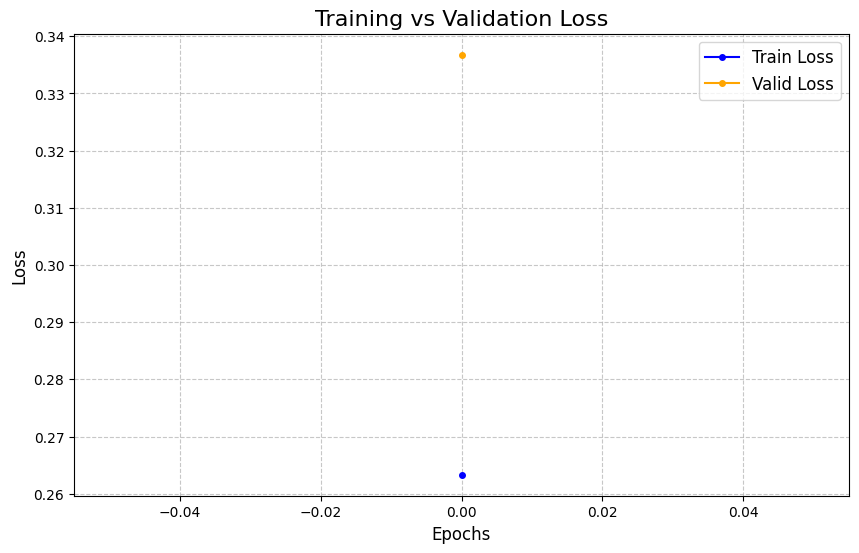

Ep 2/50 [Train]: 100%|██████████| 14310/14310 [04:25<00:00, 53.99batch/s, loss=0.1942]


   >>> Train Loss: 0.23076 | Val Loss: 0.31346
   ✓ Val loss decreased (0.33677 -> 0.31346). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


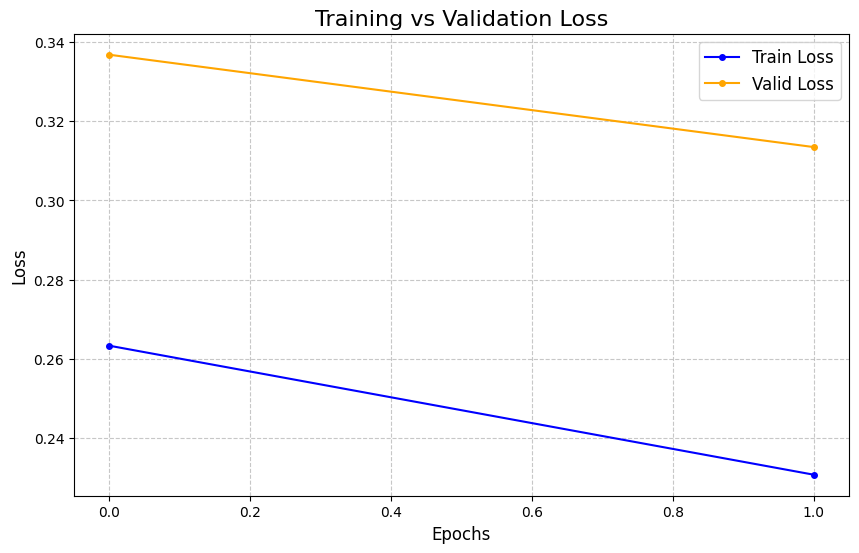

Ep 3/50 [Train]: 100%|██████████| 14310/14310 [03:32<00:00, 67.39batch/s, loss=0.1828]


   >>> Train Loss: 0.21002 | Val Loss: 0.30963
   ✓ Val loss decreased (0.31346 -> 0.30963). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


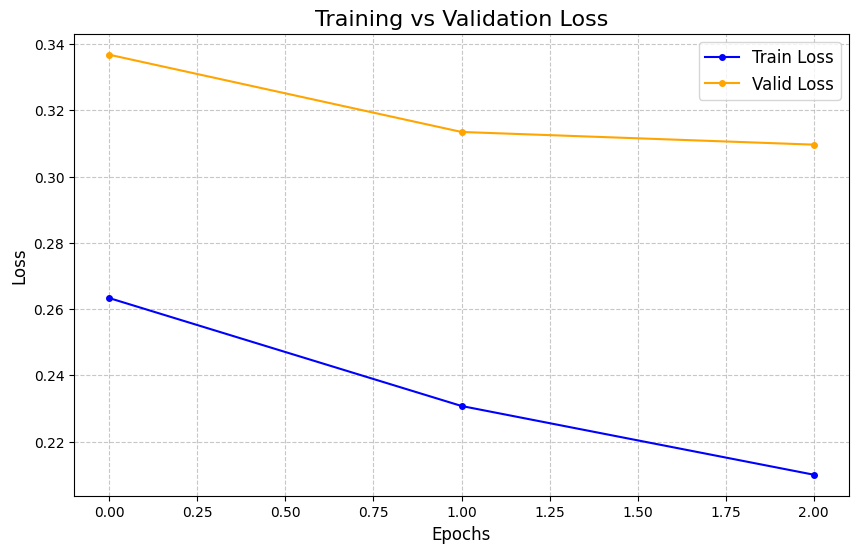

Ep 4/50 [Train]: 100%|██████████| 14310/14310 [04:42<00:00, 50.59batch/s, loss=0.2044]


   >>> Train Loss: 0.19713 | Val Loss: 0.28268
   ✓ Val loss decreased (0.30963 -> 0.28268). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


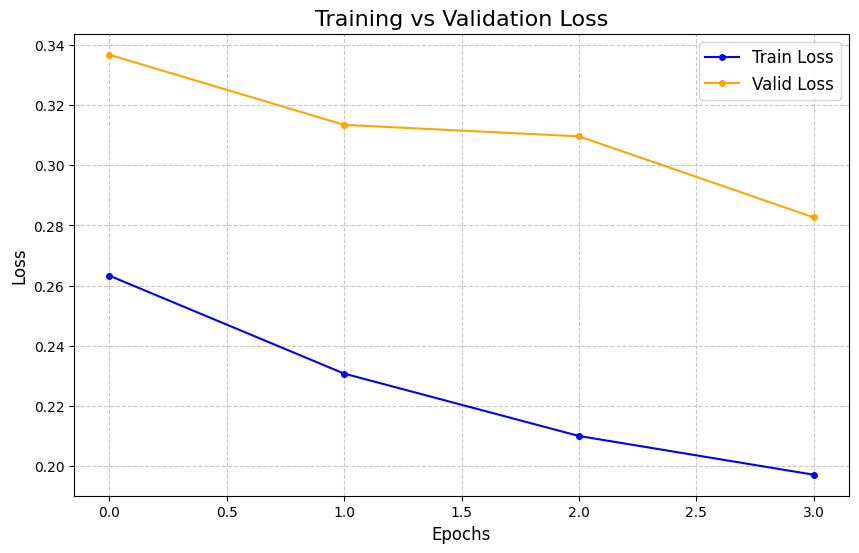

Ep 5/50 [Train]: 100%|██████████| 14310/14310 [04:27<00:00, 53.55batch/s, loss=0.1533]


   >>> Train Loss: 0.18887 | Val Loss: 0.27563
   ✓ Val loss decreased (0.28268 -> 0.27563). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


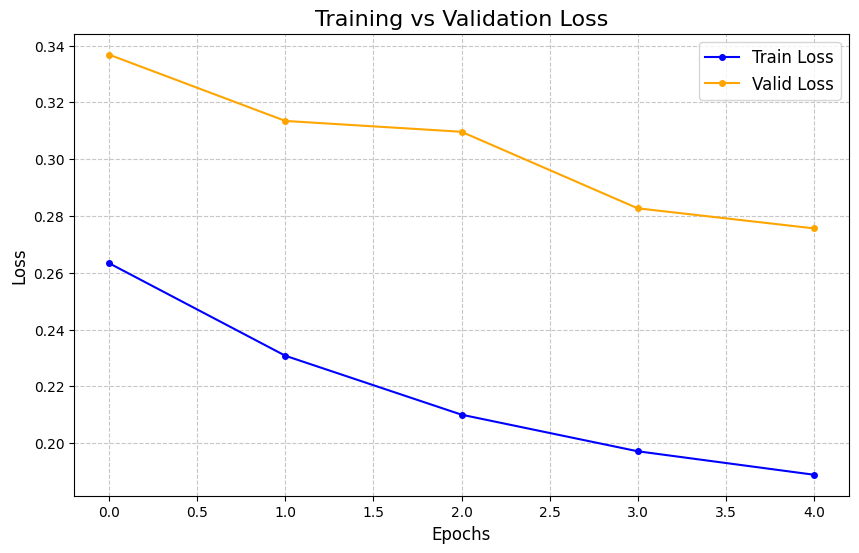

Ep 6/50 [Train]: 100%|██████████| 14310/14310 [04:33<00:00, 52.37batch/s, loss=0.1841]


   >>> Train Loss: 0.18320 | Val Loss: 0.26370
   ✓ Val loss decreased (0.27563 -> 0.26370). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


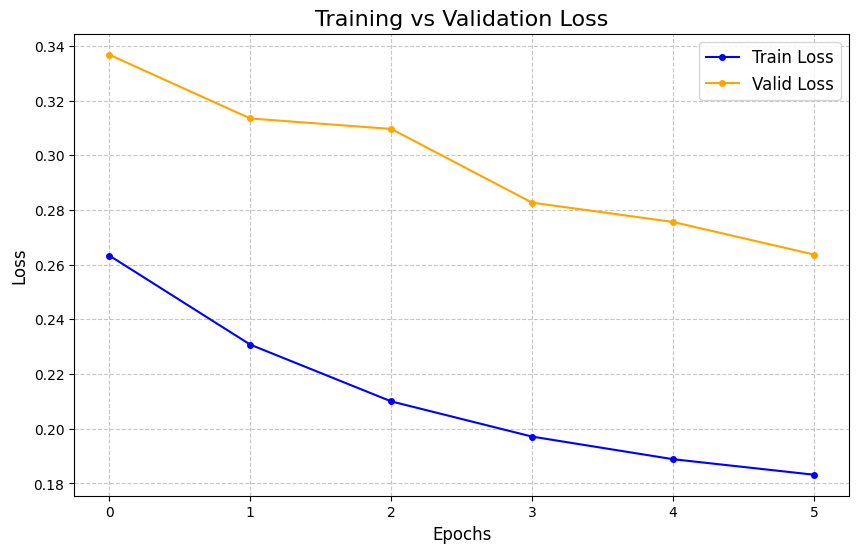

Ep 7/50 [Train]: 100%|██████████| 14310/14310 [04:26<00:00, 53.65batch/s, loss=0.1893]


   >>> Train Loss: 0.17845 | Val Loss: 0.26442
   ! EarlyStopping counter: 1/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


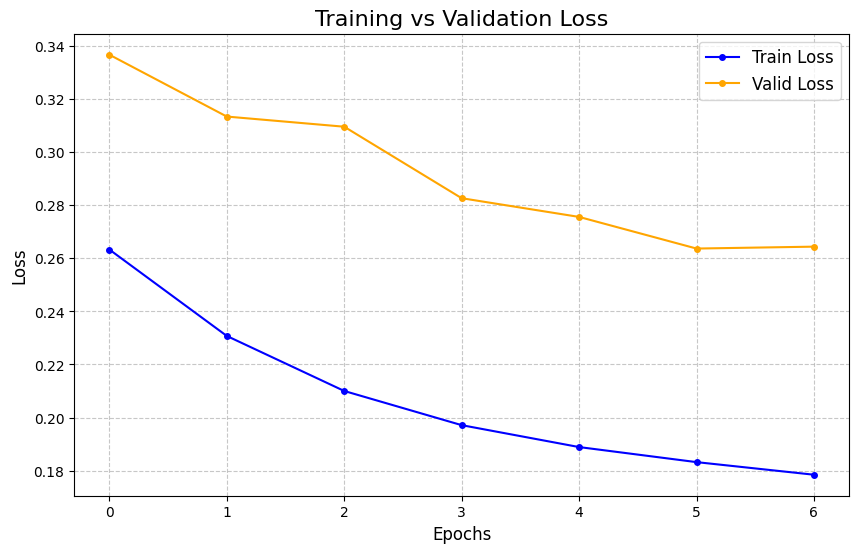

Ep 8/50 [Train]: 100%|██████████| 14310/14310 [04:04<00:00, 58.54batch/s, loss=0.1903]


   >>> Train Loss: 0.17546 | Val Loss: 0.26418
   ! EarlyStopping counter: 2/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


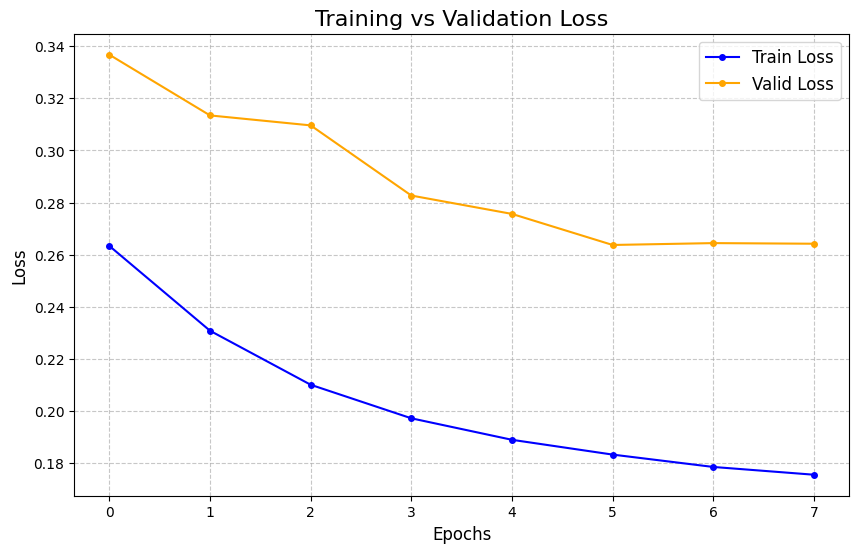

Ep 9/50 [Train]: 100%|██████████| 14310/14310 [04:00<00:00, 59.50batch/s, loss=0.1599]


   >>> Train Loss: 0.17262 | Val Loss: 0.25909
   ✓ Val loss decreased (0.26370 -> 0.25909). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


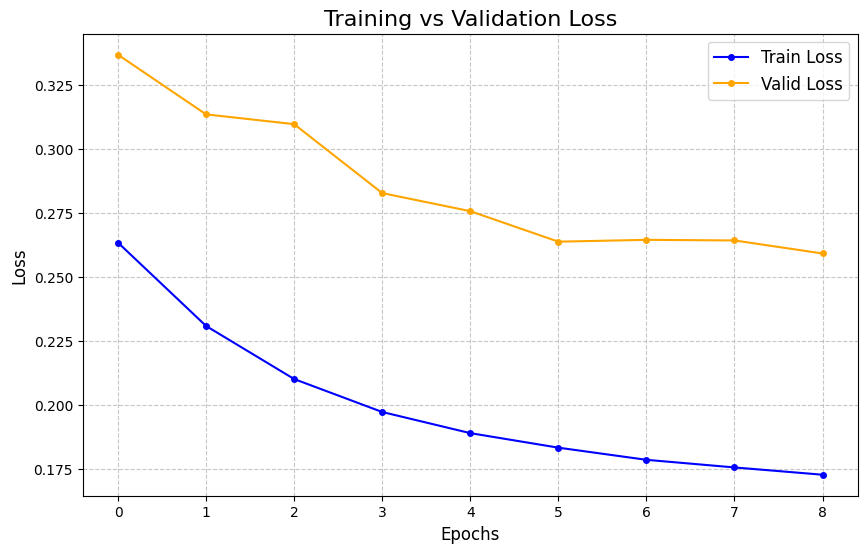

Ep 10/50 [Train]: 100%|██████████| 14310/14310 [04:20<00:00, 54.96batch/s, loss=0.1286]


   >>> Train Loss: 0.17039 | Val Loss: 0.24917
   ✓ Val loss decreased (0.25909 -> 0.24917). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


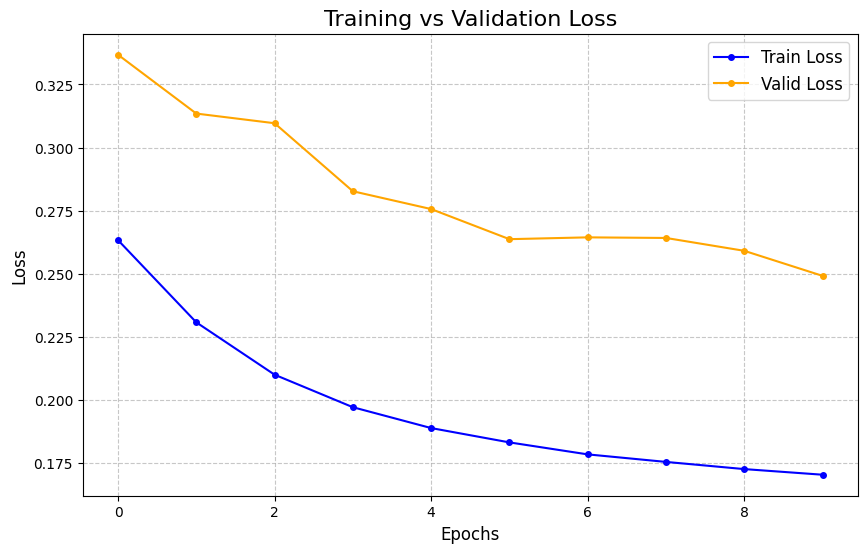

Ep 11/50 [Train]: 100%|██████████| 14310/14310 [04:17<00:00, 55.65batch/s, loss=0.1643]


   >>> Train Loss: 0.16839 | Val Loss: 0.25484
   ! EarlyStopping counter: 1/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


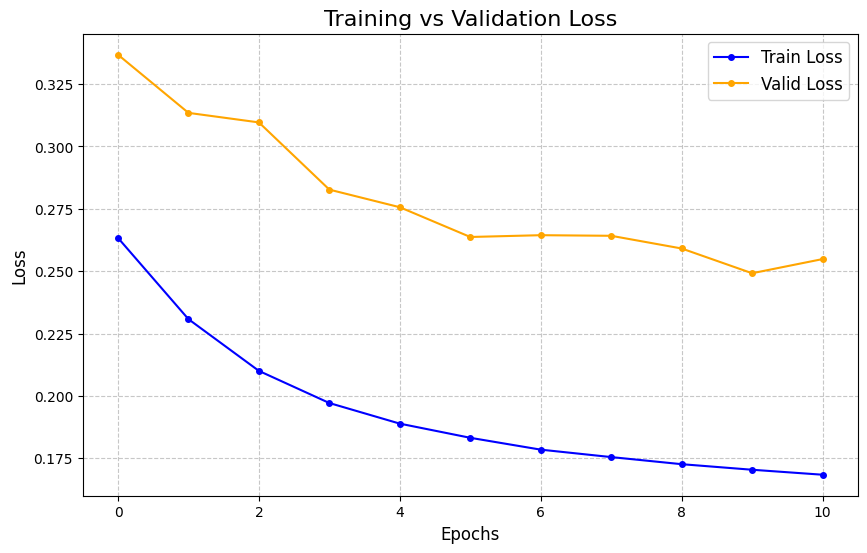

Ep 12/50 [Train]: 100%|██████████| 14310/14310 [03:48<00:00, 62.50batch/s, loss=0.1846]


   >>> Train Loss: 0.16630 | Val Loss: 0.24712
   ✓ Val loss decreased (0.24917 -> 0.24712). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


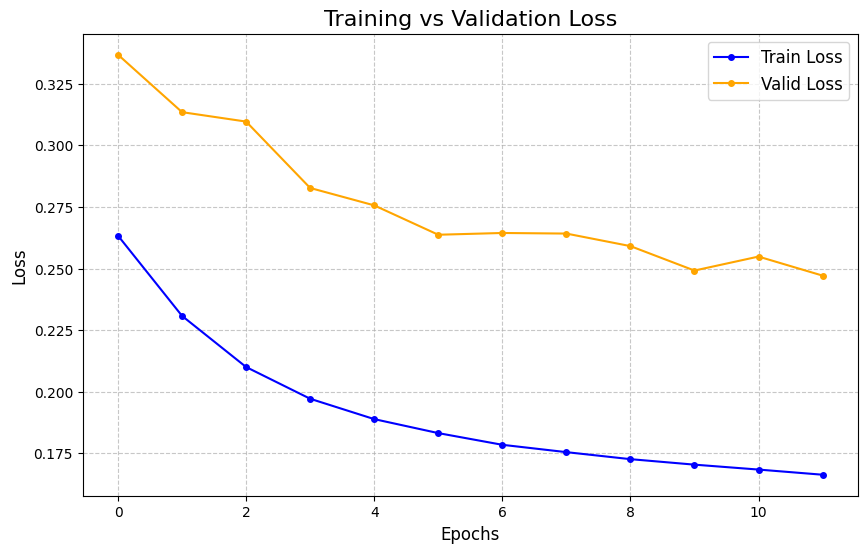

Ep 13/50 [Train]: 100%|██████████| 14310/14310 [04:06<00:00, 58.11batch/s, loss=0.1513]


   >>> Train Loss: 0.16490 | Val Loss: 0.24143
   ✓ Val loss decreased (0.24712 -> 0.24143). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


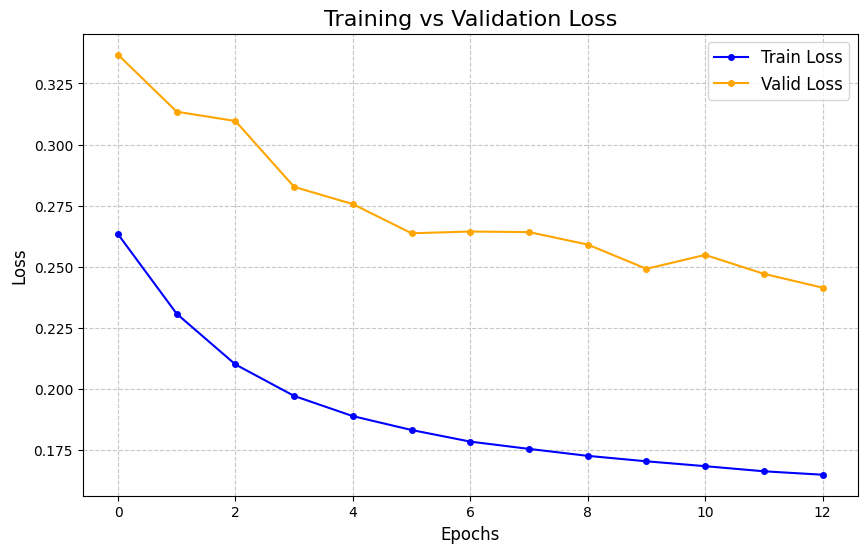

Ep 14/50 [Train]: 100%|██████████| 14310/14310 [03:43<00:00, 63.92batch/s, loss=0.1679]


   >>> Train Loss: 0.16342 | Val Loss: 0.23930
   ✓ Val loss decreased (0.24143 -> 0.23930). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


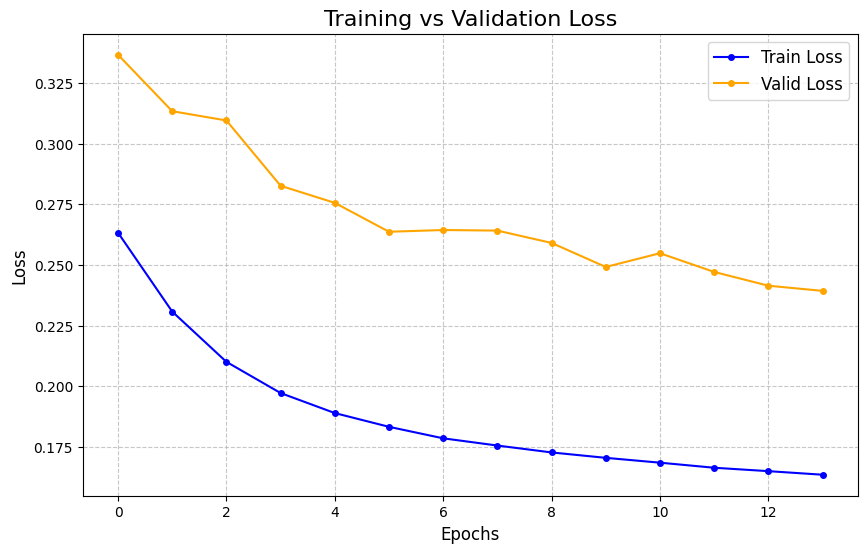

Ep 15/50 [Train]: 100%|██████████| 14310/14310 [03:31<00:00, 67.64batch/s, loss=0.1825]


   >>> Train Loss: 0.16228 | Val Loss: 0.23457
   ✓ Val loss decreased (0.23930 -> 0.23457). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


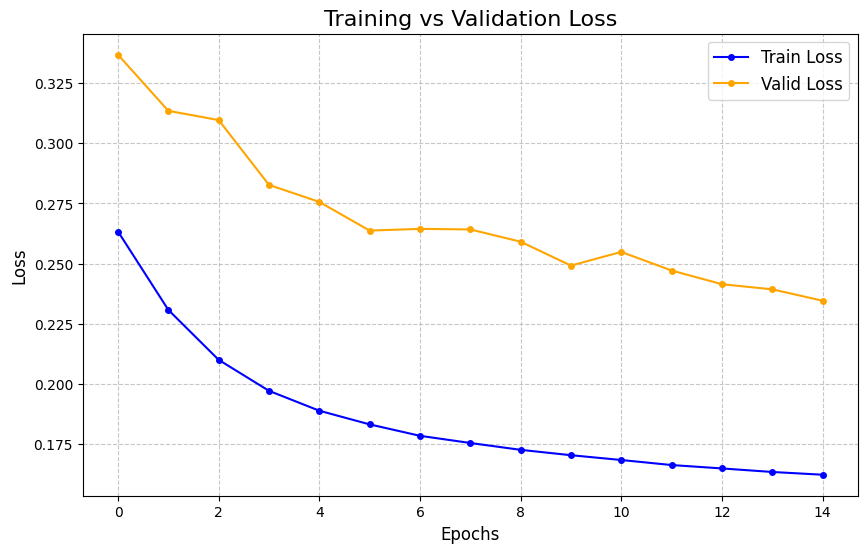

Ep 16/50 [Train]: 100%|██████████| 14310/14310 [04:18<00:00, 55.33batch/s, loss=0.1761]


   >>> Train Loss: 0.16069 | Val Loss: 0.22788
   ✓ Val loss decreased (0.23457 -> 0.22788). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


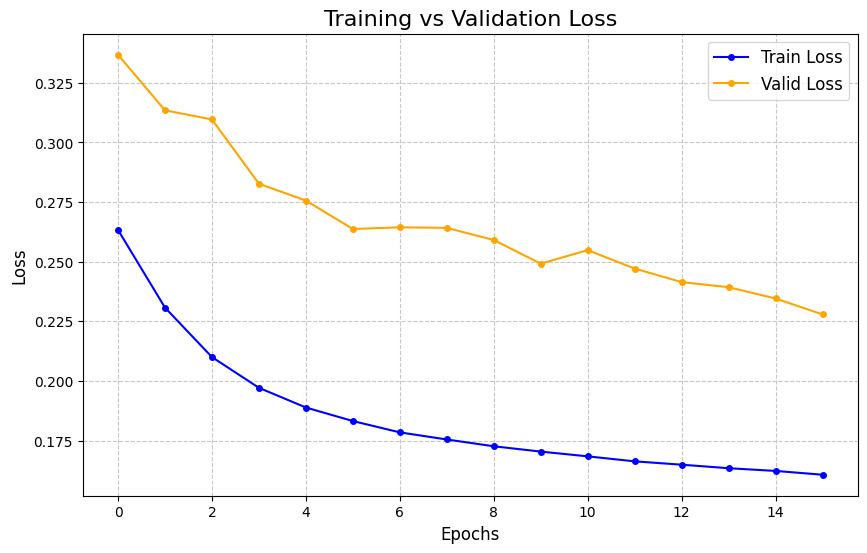

Ep 17/50 [Train]: 100%|██████████| 14310/14310 [04:48<00:00, 49.59batch/s, loss=0.1386]


   >>> Train Loss: 0.16011 | Val Loss: 0.23109
   ! EarlyStopping counter: 1/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


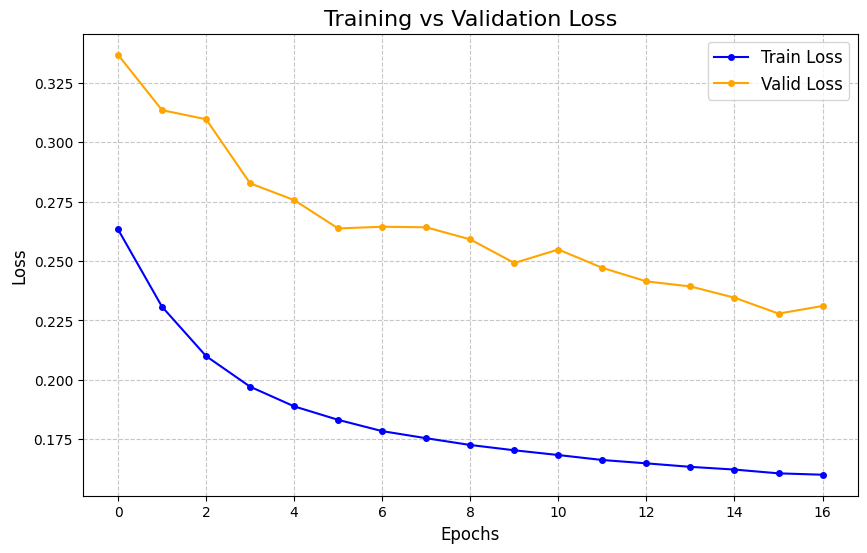

Ep 18/50 [Train]: 100%|██████████| 14310/14310 [04:10<00:00, 57.23batch/s, loss=0.1348]


   >>> Train Loss: 0.15936 | Val Loss: 0.22806
   ! EarlyStopping counter: 2/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


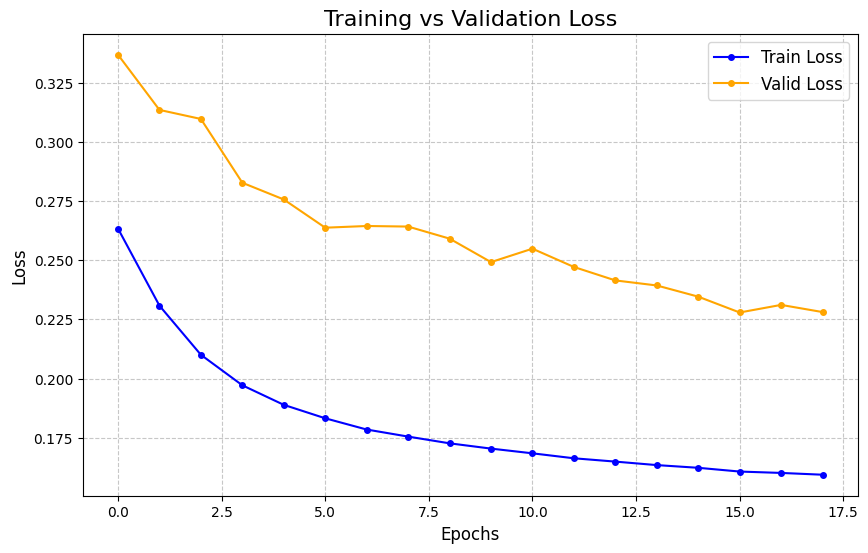

Ep 19/50 [Train]: 100%|██████████| 14310/14310 [04:20<00:00, 54.95batch/s, loss=0.1773]


   >>> Train Loss: 0.15847 | Val Loss: 0.22760
   ✓ Val loss decreased (0.22788 -> 0.22760). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


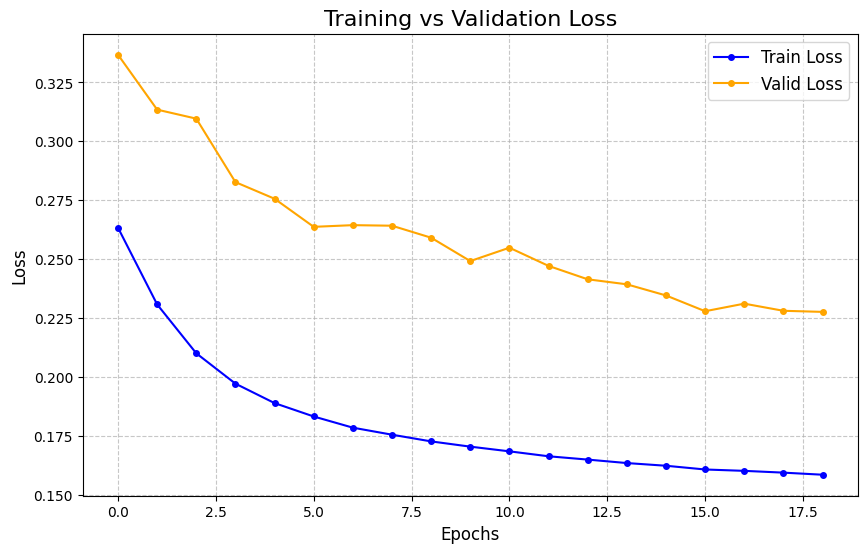

Ep 20/50 [Train]: 100%|██████████| 14310/14310 [04:43<00:00, 50.45batch/s, loss=0.1317]


   >>> Train Loss: 0.15724 | Val Loss: 0.23358
   ! EarlyStopping counter: 1/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


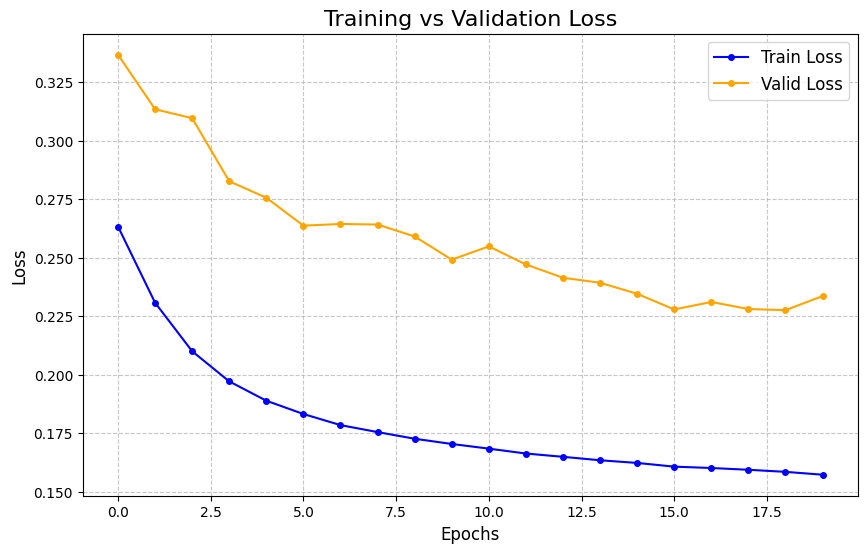

Ep 21/50 [Train]: 100%|██████████| 14310/14310 [04:24<00:00, 54.04batch/s, loss=0.1727]


   >>> Train Loss: 0.15663 | Val Loss: 0.22626
   ✓ Val loss decreased (0.22760 -> 0.22626). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


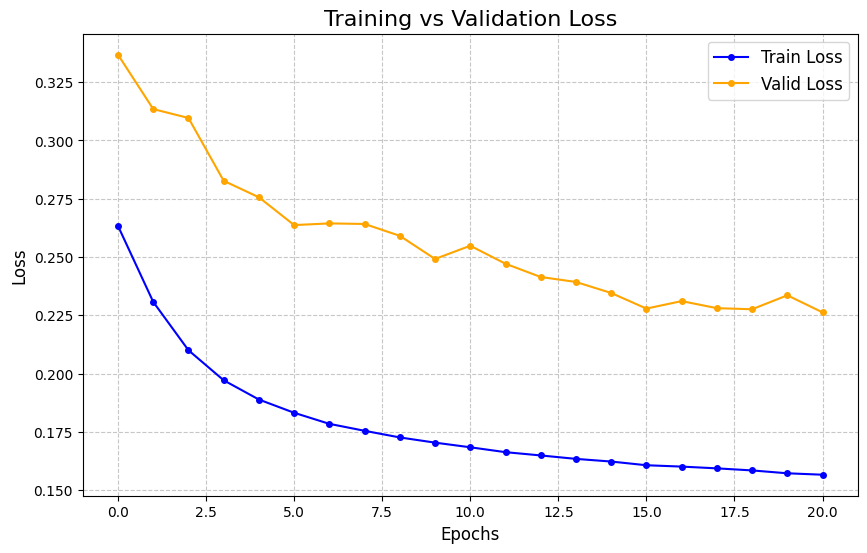

Ep 22/50 [Train]: 100%|██████████| 14310/14310 [04:28<00:00, 53.37batch/s, loss=0.1343]


   >>> Train Loss: 0.15573 | Val Loss: 0.22134
   ✓ Val loss decreased (0.22626 -> 0.22134). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


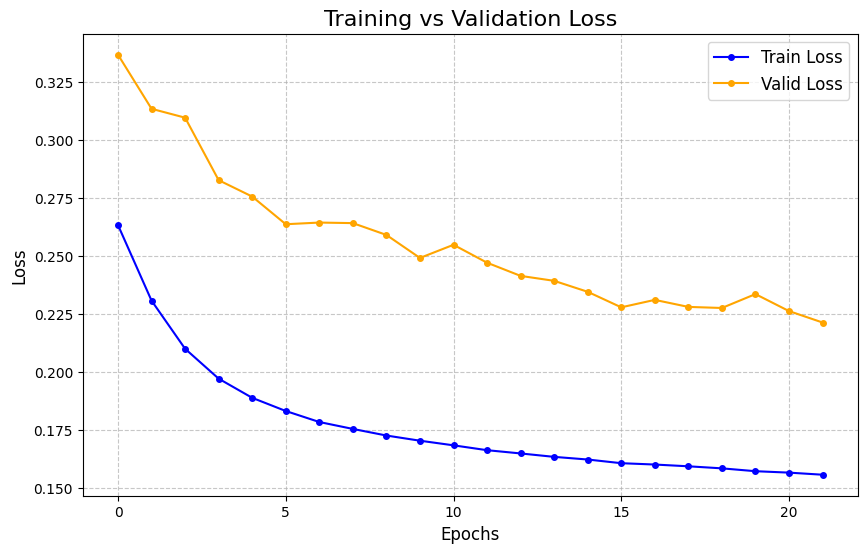

Ep 23/50 [Train]: 100%|██████████| 14310/14310 [04:24<00:00, 54.01batch/s, loss=0.1321]


   >>> Train Loss: 0.15495 | Val Loss: 0.22615
   ! EarlyStopping counter: 1/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


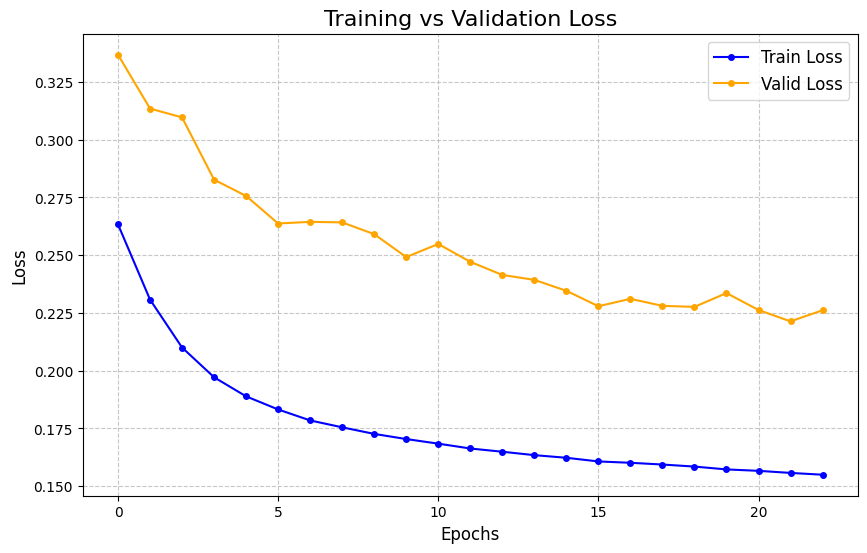

Ep 24/50 [Train]: 100%|██████████| 14310/14310 [04:08<00:00, 57.47batch/s, loss=0.1757]


   >>> Train Loss: 0.15422 | Val Loss: 0.22470
   ! EarlyStopping counter: 2/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


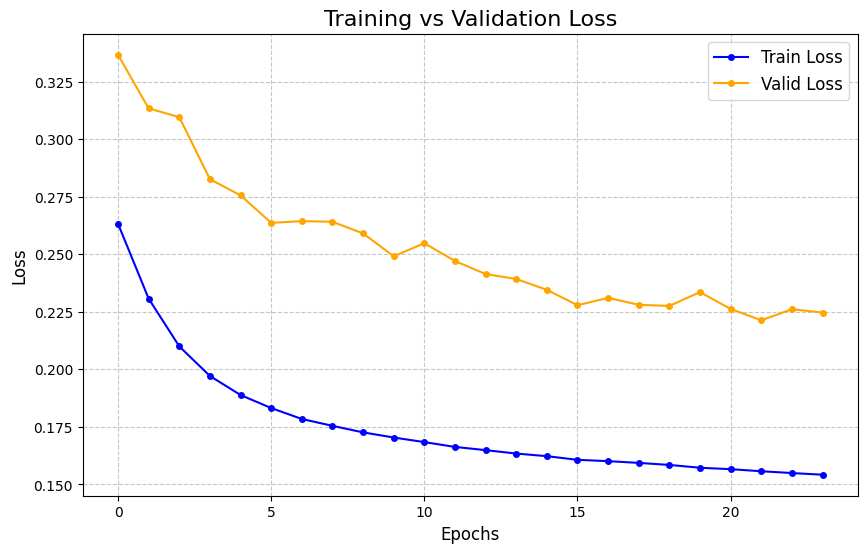

Ep 25/50 [Train]: 100%|██████████| 14310/14310 [04:36<00:00, 51.75batch/s, loss=0.1362]


   >>> Train Loss: 0.15328 | Val Loss: 0.21999
   ✓ Val loss decreased (0.22134 -> 0.21999). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


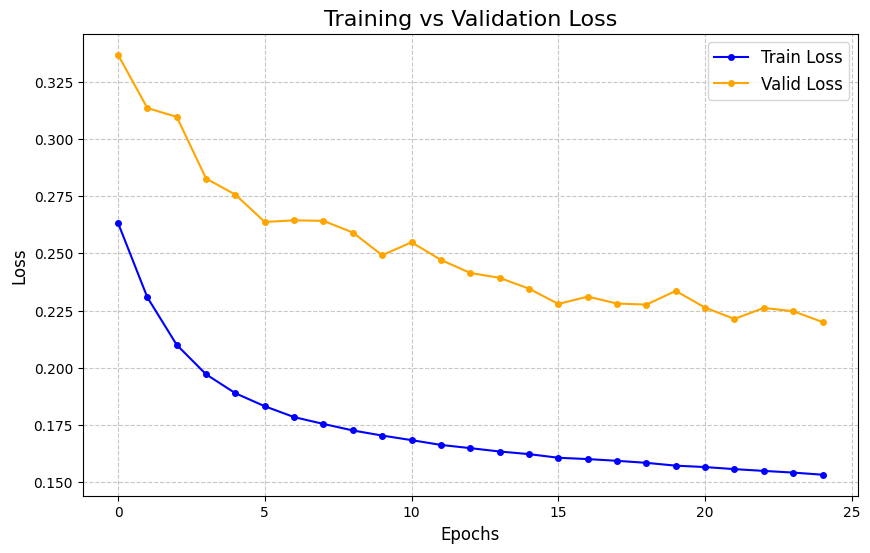

Ep 26/50 [Train]: 100%|██████████| 14310/14310 [04:10<00:00, 57.16batch/s, loss=0.1374]


   >>> Train Loss: 0.15285 | Val Loss: 0.21378
   ✓ Val loss decreased (0.21999 -> 0.21378). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


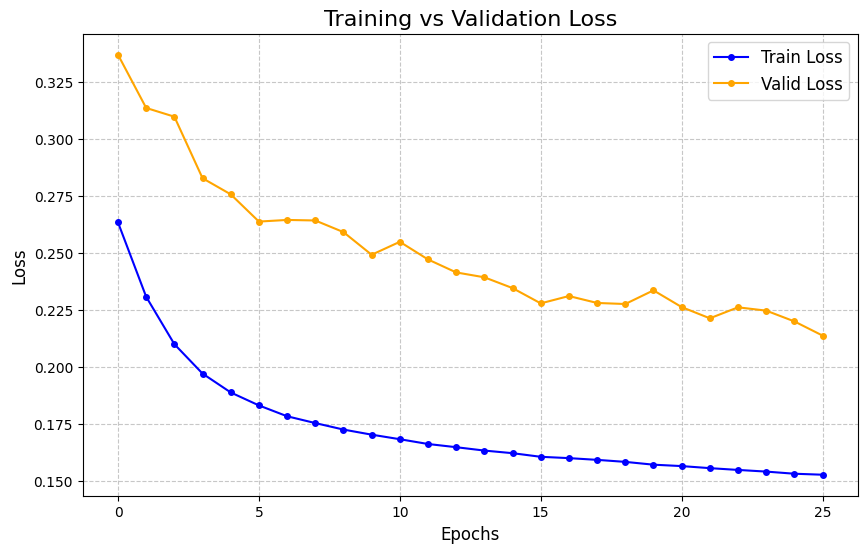

Ep 27/50 [Train]: 100%|██████████| 14310/14310 [03:38<00:00, 65.45batch/s, loss=0.1546]


   >>> Train Loss: 0.15228 | Val Loss: 0.21237
   ✓ Val loss decreased (0.21378 -> 0.21237). Saving model...

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


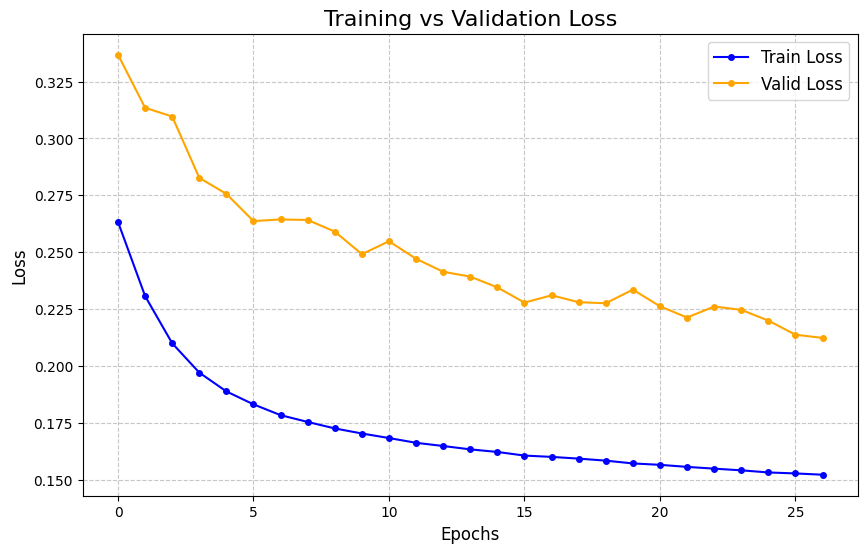

Ep 28/50 [Train]: 100%|██████████| 14310/14310 [04:13<00:00, 56.38batch/s, loss=0.1496]


   >>> Train Loss: 0.15160 | Val Loss: 0.21571
   ! EarlyStopping counter: 1/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


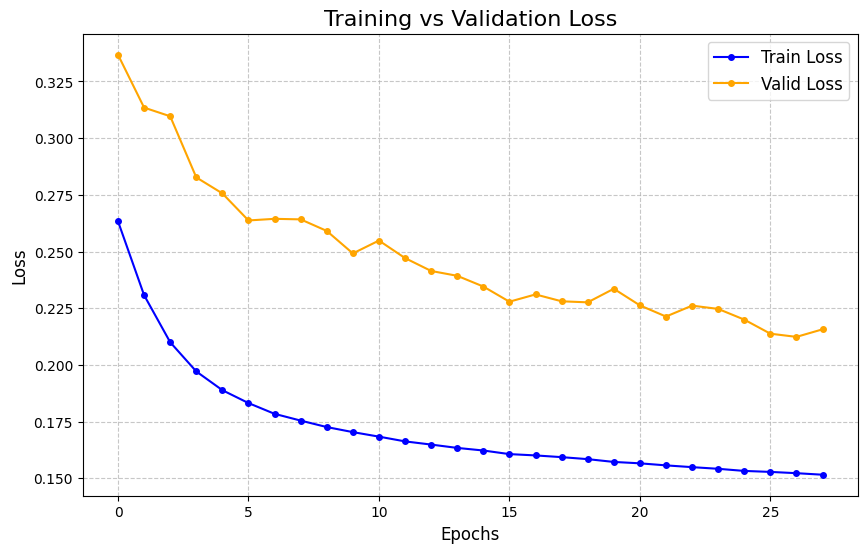

Ep 29/50 [Train]: 100%|██████████| 14310/14310 [04:57<00:00, 48.07batch/s, loss=0.1415]


   >>> Train Loss: 0.15100 | Val Loss: 0.22211
   ! EarlyStopping counter: 2/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


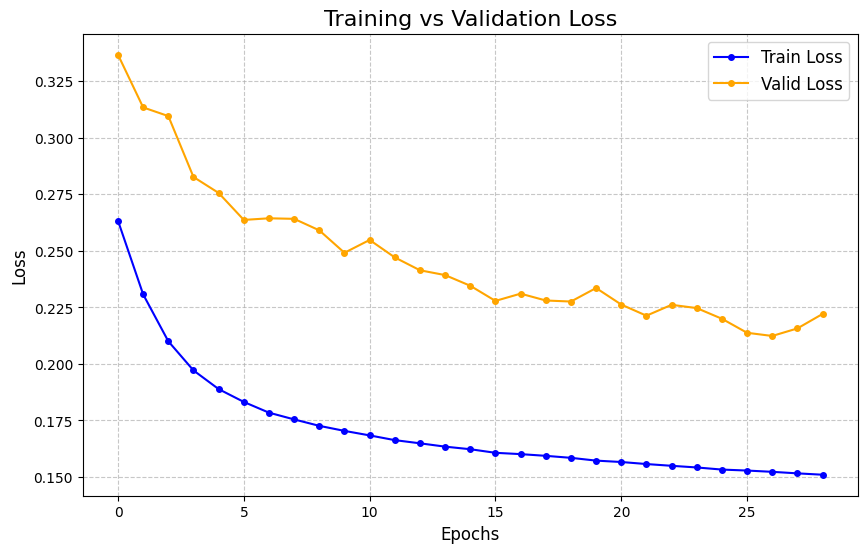

Ep 30/50 [Train]: 100%|██████████| 14310/14310 [03:24<00:00, 69.94batch/s, loss=0.1373]


   >>> Train Loss: 0.15077 | Val Loss: 0.21863
   ! EarlyStopping counter: 3/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


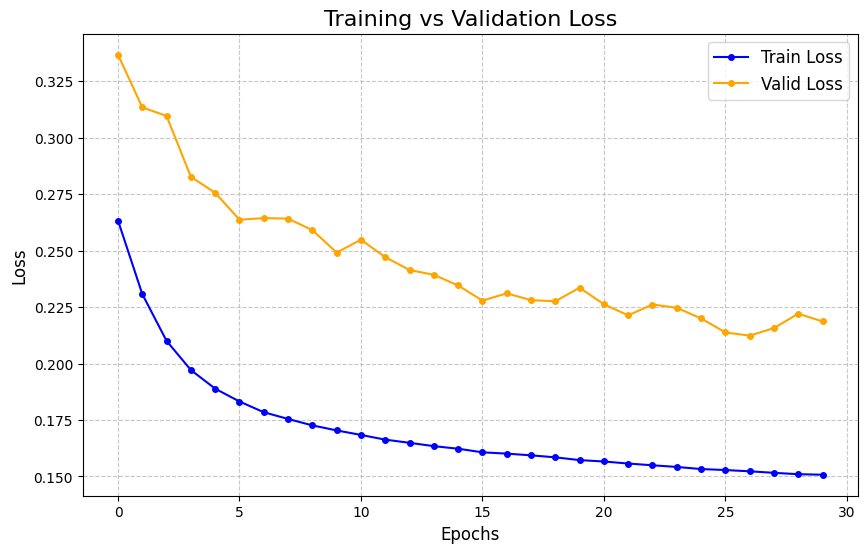

Ep 31/50 [Train]: 100%|██████████| 14310/14310 [03:15<00:00, 73.13batch/s, loss=0.1694]


   >>> Train Loss: 0.15023 | Val Loss: 0.21575
   ! EarlyStopping counter: 4/5

[INFO] Đã lưu biểu đồ Loss tại: training_loss_curve.png


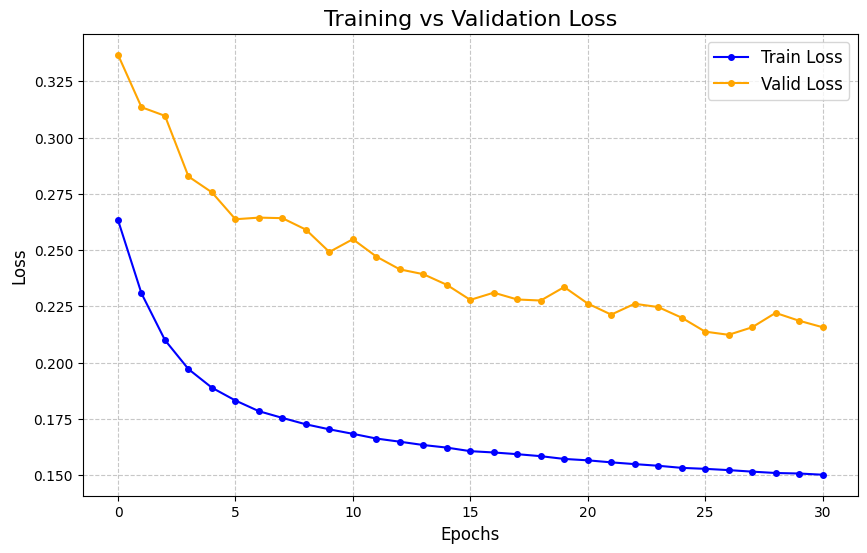

Ep 32/50 [Train]: 100%|██████████| 14310/14310 [03:23<00:00, 70.30batch/s, loss=0.1505]


   >>> Train Loss: 0.14741 | Val Loss: 0.21375
   ! EarlyStopping counter: 5/5

[!] Early stopping triggered at epoch 32!

Training completed in 151.9 minutes


In [18]:
# =============================================================================
# 9. TRAINING LOOP WITH MIXED PRECISION
# =============================================================================
import torch.cuda.amp as amp


def train_model(n_epochs, loaders, model, optimizer, criterion, scheduler, device, save_path='model_onthefly.pt'):
    valid_loss_min = np.inf
    train_loss_history = []
    valid_loss_history = []

    # --- UPDATE 1: Check device type cho AMP ---
    # Nếu device là cuda thì dùng 'cuda', ngược lại là 'cpu' (dù cpu amp ít dùng hơn)
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'
    use_amp = (device_type == 'cuda')

    # --- UPDATE 2: Sử dụng torch.amp.GradScaler (API Mới) ---
    # GradScaler chỉ có tác dụng khi device là cuda
    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    # Early Stopping params
    patience = 5
    counter = 0

    print("="*70)
    print(f"TRAINING START | Device: {device} | AMP: {'Enabled' if use_amp else 'Disabled'}")
    print("="*70)

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        # --- TRAIN ---
        model.train()
        pbar = tqdm(loaders['train'], desc=f"Ep {epoch}/{n_epochs} [Train]", unit="batch")

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            # --- UPDATE 3: set_to_none=True để tối ưu tốc độ ---
            optimizer.zero_grad(set_to_none=True)

            # --- UPDATE 4: Sử dụng torch.amp.autocast (API Mới) ---
            # Bắt buộc phải có tham số device_type
            with torch.amp.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
                output = model(data)
                loss = criterion(output, target)

            # Backward pass với scaler
            if use_amp:
                scaler.scale(loss).backward()

                # --- UPDATE 5: Gradient Clipping (An toàn cho Mixed Precision) ---
                # Unscale trước khi clip để đảm bảo giá trị đúng
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            train_loss += loss.item() * data.size(0)
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # --- VALIDATE ---
        model.eval()
        with torch.no_grad():
            for data, target in loaders['valid']:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

                # Validation cũng nên dùng autocast để tiết kiệm VRAM
                with torch.amp.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
                    output = model(data)
                    loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)

        # Calculate average losses
        train_loss = train_loss / len(loaders['train'].dataset)
        valid_loss = valid_loss / len(loaders['valid'].dataset)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        print(f"   >>> Train Loss: {train_loss:.5f} | Val Loss: {valid_loss:.5f}")

        # Scheduler Step
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(valid_loss)
        else:
            scheduler.step()

        # Checkpoint & Early Stopping
        if valid_loss <= valid_loss_min:
            print(f"   ✓ Val loss decreased ({valid_loss_min:.5f} -> {valid_loss:.5f}). Saving model...")
            # Lưu cả state dict của model và optimizer để có thể resume sau này nếu cần
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            counter = 0
        else:
            counter += 1
            print(f"   ! EarlyStopping counter: {counter}/{patience}")
            if counter >= patience:
                print(f"\n[!] Early stopping triggered at epoch {epoch}!")
                break
        plot_and_save_loss(train_loss_history, valid_loss_history, save_path='training_loss_curve.png')

    return model


print(f"\nStarting training at {time.strftime('%H:%M:%S')}...\n")
start_time = time.time()

# Gọi hàm train_model đã sửa
trained_model = train_model(
    n_epochs=N_EPOCHS,       # Số lượng Epoch (ví dụ 30)
    loaders=loaders,         # Dictionary chứa train/val/test loaders
    model=model,             # Mô hình EfficientNetV2-S đã khởi tạo
    optimizer=optimizer,     # Adam optimizer
    criterion=criterion,     # CrossEntropyLoss (có weights)
    scheduler=scheduler,     # Learning rate scheduler
    device=device,           # 'cuda' hoặc 'cpu'
    save_path='model_best.pt' # Tên file để lưu model tốt nhất
)

elapsed = time.time() - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes")


Loading best model weights...
Evaluating on Test Set (Scenario 10)...


Testing: 100%|██████████| 1173/1173 [00:10<00:00, 107.06it/s]



CLASSIFICATION REPORT (Dùng cho Table trong bài báo)
              precision    recall  f1-score   support

      Botnet     0.0348    0.9597    0.0672      5134
         C&C     0.0015    0.8485    0.0029        33
      Normal     0.9998    0.8698    0.9303   1195173

    accuracy                         0.8702   1200340
   macro avg     0.3454    0.8926    0.3335   1200340
weighted avg     0.9956    0.8702    0.9266   1200340


Saved confusion matrix to 'confusion_matrix_scenario10.png'


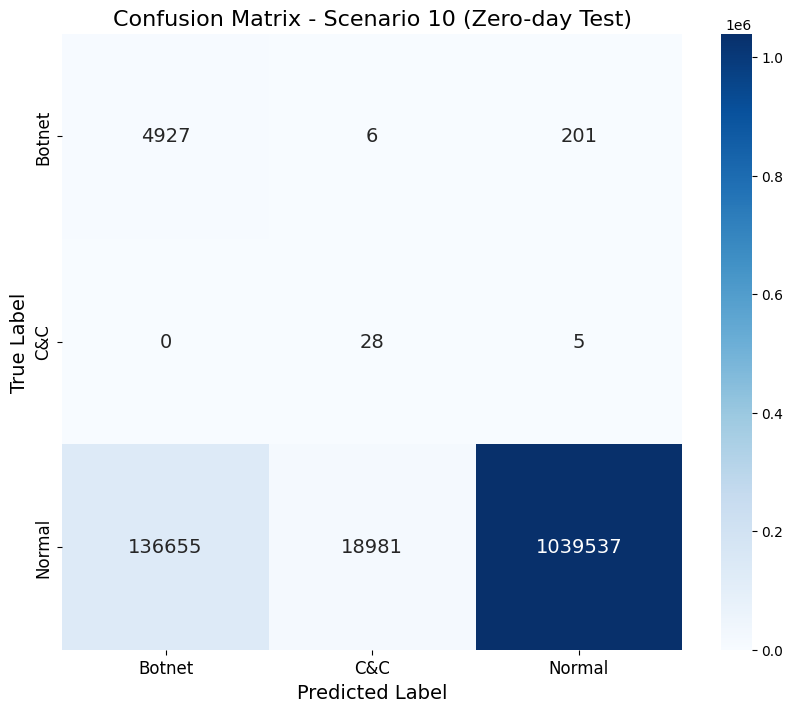


Overall Accuracy: 0.8702


0.8701634536881216

In [ ]:
# =============================================================================
# 10. EVALUATION & METRICS (For Paper)
# =============================================================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(loader, model, device, class_names):
    """
    Hàm đánh giá toàn diện, trả về báo cáo chi tiết và vẽ Confusion Matrix
    """
    model.eval() # Chuyển sang chế độ đánh giá (tắt Dropout, BatchNorm)

    all_preds = []
    all_targets = []

    print("Evaluating on Test Set (Scenario 10)...")

    # Không tính gradient để tiết kiệm bộ nhớ và tăng tốc
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Testing"):
            data = data.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)

            # Forward pass
            # Có thể dùng amp.autocast ở đây nếu muốn tiết kiệm VRAM, nhưng không bắt buộc
            output = model(data)

            # Lấy nhãn dự đoán (vị trí có xác suất cao nhất)
            preds = output.argmax(dim=1)

            # Chuyển về CPU và list để tính toán bằng sklearn
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # --- 1. Classification Report (Precision, Recall, F1) ---
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT (Dùng cho Table trong bài báo)")
    print("="*60)
    # digits=4 để lấy 4 chữ số thập phân cho chính xác
    report = classification_report(all_targets, all_preds, target_names=class_names, digits=4)
    print(report)

    # --- 2. Confusion Matrix (Vẽ hình cho Reviewer 2) ---
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 8))
    # Vẽ heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 14}) # Cỡ chữ số

    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title('Confusion Matrix - Scenario 10 (Zero-day Test)', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Lưu ảnh để chèn vào báo
    plt.savefig('confusion_matrix_scenario10.png', dpi=300, bbox_inches='tight')
    print("\nSaved confusion matrix to 'confusion_matrix_scenario10.png'")
    plt.show()

    # Tính Accuracy tổng thể
    acc = accuracy_score(all_targets, all_preds)
    print(f"\nOverall Accuracy: {acc:.4f}")

    return acc

# --- CHẠY ĐÁNH GIÁ ---

# 1. Load lại trọng số tốt nhất (Best Model) đã lưu lúc train
print("Loading best model weights...")
# SỬA LỖI: Dùng trained_model thay vì model (biến model đã bị ghi đè hoặc không tồn tại)
try:
    trained_model.load_state_dict(torch.load('model_best.pt', map_location=device))
except NameError:
    print("Warning: 'trained_model' not found. Re-initializing...")
    trained_model = BotnetClassifier(base_model=None, n_features=n_features, image_size=None).to(device)
    trained_model.load_state_dict(torch.load('model_best.pt', map_location=device))

# 2. Định nghĩa tên lớp (theo thứ tự 0, 1, 2)
class_names = ['Botnet', 'C&C', 'Normal']

# 3. Gọi hàm
evaluate_model(loaders['test'], trained_model, device, class_names)



# Loading best model weights...
# Evaluating on Test Set (Scenario 10)...
# Testing: 100%|██████████| 1173/1173 [00:10<00:00, 107.06it/s]

# ============================================================
# CLASSIFICATION REPORT (Dùng cho Table trong bài báo)
# ============================================================
#               precision    recall  f1-score   support

#       Botnet     0.0348    0.9597    0.0672      5134
#          C&C     0.0015    0.8485    0.0029        33
#       Normal     0.9998    0.8698    0.9303   1195173

#     accuracy                         0.8702   1200340
#    macro avg     0.3454    0.8926    0.3335   1200340
# weighted avg     0.9956    0.8702    0.9266   1200340


# Saved confusion matrix to 'confusion_matrix_scenario10.png'

In [ ]:
# =============================================================================
# 11. SAVE FINAL MODEL & METADATA
# =============================================================================

print("="*70)
print("SAVING FINAL MODEL & METADATA")
print("="*70)

# Save complete model (not just state_dict) for easier deployment
torch.save({
    'model_state_dict': trained_model.state_dict(), # Sửa: Dùng trained_model
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names,
    'image_size': global_stats['image_size'],
    'n_features': global_stats['n_features'],
}, 'model_complete.pt')
print("  Saved: model_complete.pt")

# Save global stats for inference
inference_stats = {
    'global_min': global_stats['global_min'].tolist(),
    'global_max': global_stats['global_max'].tolist(),
    'global_range': global_stats['global_range'].tolist(),
    'expected_columns': global_stats['expected_columns'],
    'top_states': global_stats['top_states'],
    'n_features': global_stats['n_features'],
    'image_size': global_stats['image_size'],
    'class_names': class_names
}

with open('inference_stats.json', 'w') as f:
    json.dump(inference_stats, f, indent=2)
print("  Saved: inference_stats.json")

# Save class weights
with open('class_weights.json', 'w') as f:
    json.dump({'Botnet': class_weights[0], 'C&C': class_weights[1], 'Normal': class_weights[2]}, f)
print("  Saved: class_weights.json")

print("\n" + "="*70)
print("PIPELINE COMPLETE!")
print("="*70)
print("\nOutput files:")
print("  - model_onthefly.pt     : Best model weights")
print("  - model_complete.pt     : Full checkpoint for deployment")
print("  - inference_stats.json  : Stats needed for inference")
print("  - class_weights.json    : Class weights")
print("  - training_history.png  : Loss curves")
print("  - confusion_matrix.png  : Test set confusion matrix")
print("\nNo image files were written to disk during this pipeline!")
print("All transformations were done on-the-fly in RAM.")

SAVING FINAL MODEL & METADATA
  Saved: model_complete.pt
  Saved: inference_stats.json
  Saved: class_weights.json

PIPELINE COMPLETE!

Output files:
  - model_onthefly.pt     : Best model weights
  - model_complete.pt     : Full checkpoint for deployment
  - inference_stats.json  : Stats needed for inference
  - class_weights.json    : Class weights
  - training_history.png  : Loss curves
  - confusion_matrix.png  : Test set confusion matrix

No image files were written to disk during this pipeline!
All transformations were done on-the-fly in RAM.


In [ ]:
# Code mẫu để so sánh với Random Forest (Thêm vào cuối notebook sau khi đã có X_all, y_all)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

print("Running Random Forest Benchmark...")
print("Running Random Forest Benchmark...")

# Dùng đúng dữ liệu đã load ở trên (Cell 5 & 8)
# Lưu ý: X_train (đã load ở trên) là mảng Numpy 85 chiều -> Chuẩn cho RF
X_train_rf = X_train
y_train_rf = y_train
X_test_rf = X_test
y_test_rf = y_test

# Train RF
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

# Evaluate
y_pred_rf = rf_model.predict(X_test_rf)
print("Random Forest Results (Scenario 10):")
print(classification_report(y_test_rf, y_pred_rf, target_names=['Botnet', 'C&C', 'Normal'], digits=4))

Running Random Forest Benchmark...
Running Random Forest Benchmark...
Random Forest Results (Scenario 10):
              precision    recall  f1-score   support

      Botnet     0.0120    0.0316    0.0173      5134
         C&C     0.0000    0.0000    0.0000        33
      Normal     0.9958    0.9888    0.9923   1195173

    accuracy                         0.9847   1200340
   macro avg     0.3359    0.3401    0.3365   1200340
weighted avg     0.9915    0.9847    0.9881   1200340



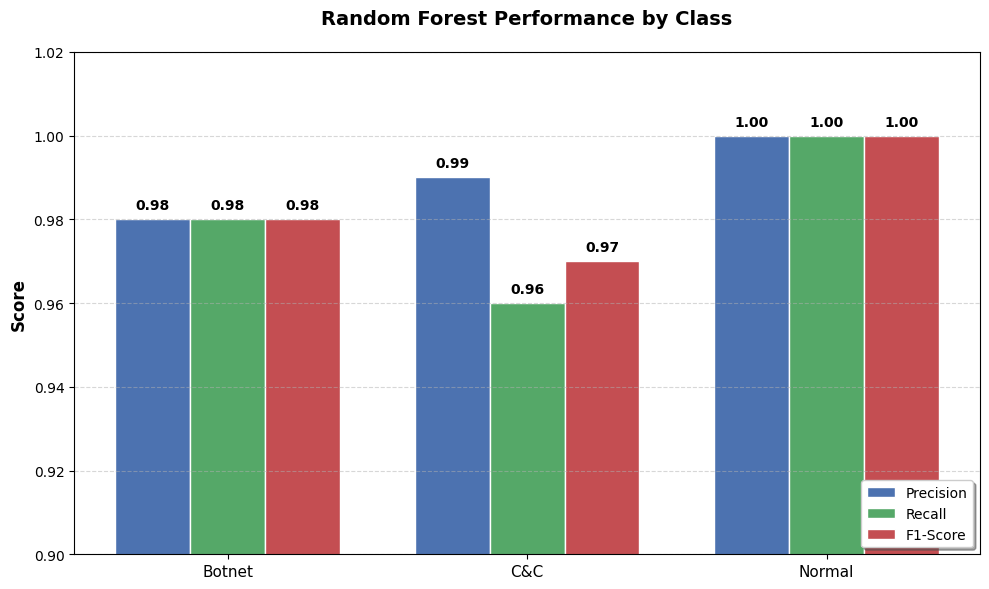

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Dữ liệu từ kết quả Random Forest của bạn ---
classes = ['Botnet', 'C&C', 'Normal']

# Số liệu bạn cung cấp
precision = [0.98, 0.99, 1.00]
recall    = [0.98, 0.96, 1.00]
f1_score  = [0.98, 0.97, 1.00]

# --- 2. Thiết lập biểu đồ ---
x = np.arange(len(classes))  # Vị trí các nhãn trên trục X
width = 0.25                 # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(10, 6))

# Vẽ 3 nhóm cột
rects1 = ax.bar(x - width, precision, width, label='Precision', color='#4c72b0', edgecolor='white')
rects2 = ax.bar(x, recall, width, label='Recall', color='#55a868', edgecolor='white')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='#c44e52', edgecolor='white')

# --- 3. Trang trí biểu đồ cho chuẩn Academic ---
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Performance by Class', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=11)
ax.set_ylim(0.90, 1.02)  # Zoom vào khoảng 0.9-1.0 để thấy rõ sự chênh lệch
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# --- 4. Hàm thêm số liệu lên đầu cột ---
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()

# --- 5. Lưu ảnh để chèn vào báo ---
plt.savefig('rf_benchmark_results.png', dpi=300) # Lưu file chất lượng cao (300 DPI)
plt.show()